In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.preprocessing.image import image_dataset_from_directory
import os
from PIL import Image
from model_params import *
from dataTransformer import *
#tf.disable_v2_behavior()
import time


%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Loading data

In [3]:
DATA_ROOT = "asl_alphabet_train/"
batch_size = BATCH_SIZE
img_height,img_width,img_channels = IMG_DIM
OVERWRITE_MODEL = False
seed = 12353
validation_split = 0.2
AUTOTUNE = tf.data.AUTOTUNE
DO_TRANSFORM = True

In [4]:
train_ds,val_ds,test_ds,class_names = load_dataset(DATA_ROOT,seed=seed)
num_classes = len(class_names)

Found 87000 files belonging to 29 classes.
Using 52200 files for training.
Found 87000 files belonging to 29 classes.
Using 34800 files for validation.
Splitting validation into validation and test
Using 17400 files for validation and 17400 files for test


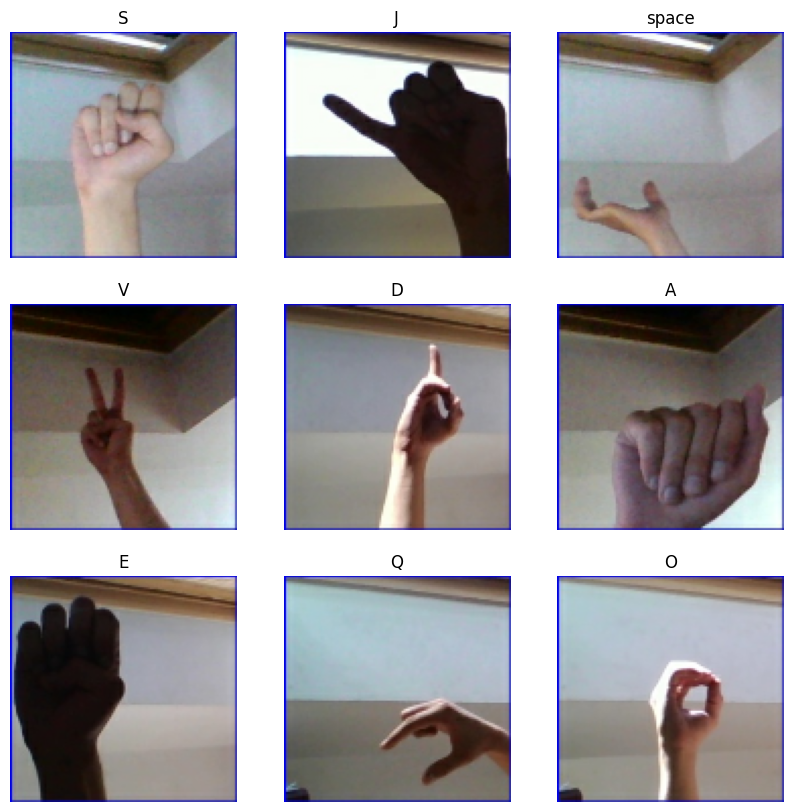

In [5]:
plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img.numpy())
  plt.title(class_names[label])
  plt.axis("off")

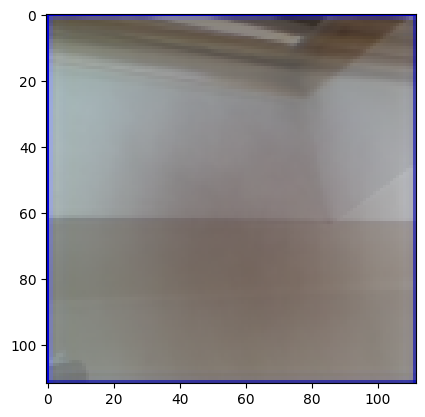

In [6]:
running_sum = tf.zeros(INPUT_SHAPE)

for img, lable in train_ds.take(1000):
    
    running_sum = running_sum+(img/1000.0)
plt.imshow(running_sum.numpy())

# Preprocessing

In [7]:
tmp = train_ds

In [8]:
train_ds = tmp

In [9]:
from dataTransformer import random_transformations

if DO_TRANSFORM:
    train_ds = train_ds.map(random_transformations, num_parallel_calls=AUTOTUNE)

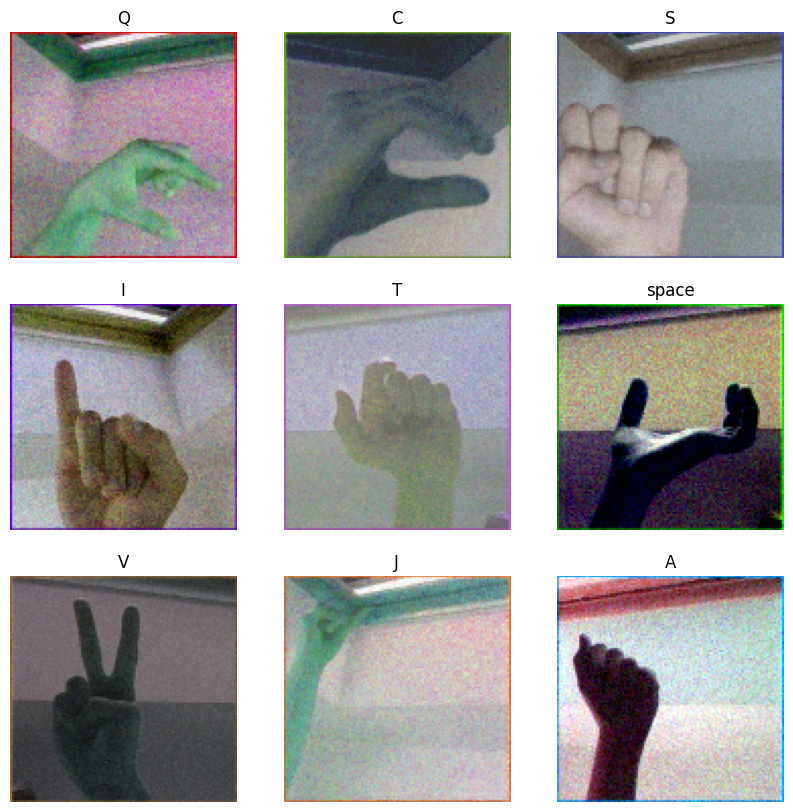

In [10]:
plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(train_ds.take(9)):
  
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img.numpy())
  plt.title(class_names[label])
  plt.axis("off")

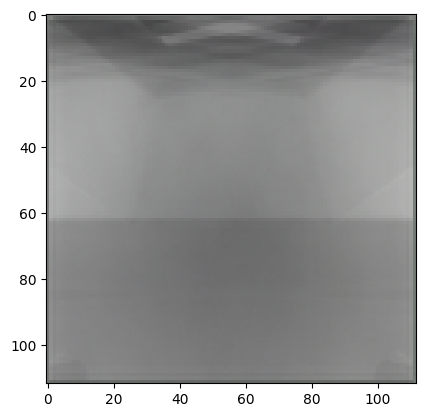

In [11]:
running_sum = tf.zeros(INPUT_SHAPE)
img_num = 0
for img, lable in train_ds.take(1000):
    running_sum = running_sum+((img)/1000.0)
plt.imshow(running_sum.numpy())

In [12]:
train_ds = train_ds.batch(batch_size,num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Baseline model

Simple linear regression

In [13]:
lr_model = tf.keras.Sequential([
  tf.keras.layers.Resizing(INPUT_SHAPE[0]//2,INPUT_SHAPE[1]//2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes)
])

#using rms optimizer 
lr_model.compile(
  optimizer='rmsprop',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

lr_model.build([None,INPUT_SHAPE[0],INPUT_SHAPE[1],INPUT_SHAPE[2]])
lr_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 56, 56, 3)         0         
                                                                 
 flatten (Flatten)           (None, 9408)              0         
                                                                 
 dense (Dense)               (None, 29)                272861    
                                                                 
Total params: 272,861
Trainable params: 272,861
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_backup_callback = tf.keras.callbacks.BackupAndRestore(
    backup_dir=BACKUP_FILEPATH+"/lr_model")

trained = False

if OVERWRITE_MODEL or not os.path.exists(MODEL_DIR+"/lr_model.keras"):
    
  history = lr_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=150,callbacks=[model_backup_callback]
  )
  trained = True
else:
  lr_model.load_weights(MODEL_DIR+"/lr_model.keras")



Epoch 1/150
1632/1632 [==============================] - 15s 9ms/step - loss: 7.5140 - accuracy: 0.0703 - val_loss: 9.7341 - val_accuracy: 0.0666
Epoch 2/150
1632/1632 [==============================] - 8s 5ms/step - loss: 6.8476 - accuracy: 0.1017 - val_loss: 10.8148 - val_accuracy: 0.0746
Epoch 3/150
1632/1632 [==============================] - 8s 5ms/step - loss: 6.6127 - accuracy: 0.1136 - val_loss: 10.1972 - val_accuracy: 0.0598
Epoch 4/150
1632/1632 [==============================] - 8s 5ms/step - loss: 6.3992 - accuracy: 0.1260 - val_loss: 8.5516 - val_accuracy: 0.0891
Epoch 5/150
1632/1632 [==============================] - 8s 5ms/step - loss: 6.2863 - accuracy: 0.1328 - val_loss: 6.0332 - val_accuracy: 0.1174
Epoch 6/150
1632/1632 [==============================] - 8s 5ms/step - loss: 6.1383 - accuracy: 0.1449 - val_loss: 12.0453 - val_accuracy: 0.1075
Epoch 7/150
1632/1632 [==============================] - 8s 5ms/step - loss: 6.0817 - accuracy: 0.1503 - val_loss: 7.6164 - va

In [15]:
lr_res = evaluate_model(lr_model,test_ds,verbose=3,savePath=MODEL_DIR+"/lr_model.keras")

544/544 [==============================] - 4s 4ms/step - loss: 5.0099 - accuracy: 0.2780
Test loss: 5.0098748207092285
Test accuracy: 0.27804598212242126
Model saved to models/lr_model.keras


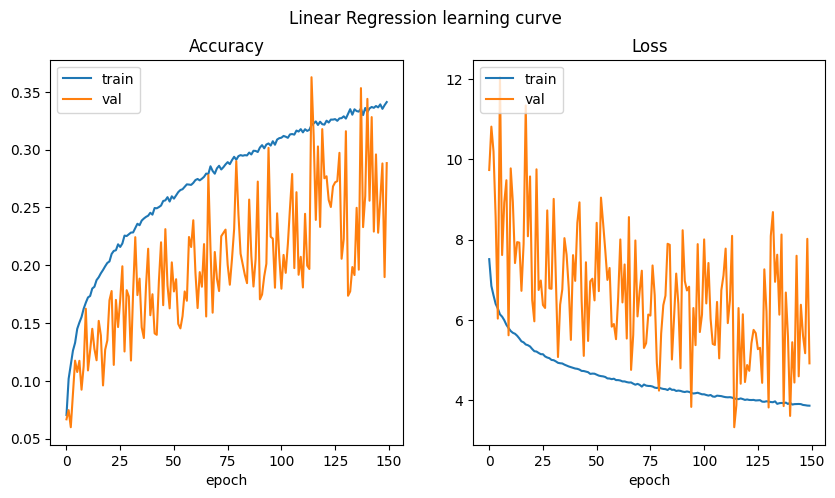

In [16]:
if trained:
    plot_curves(history, title="Linear Regression learning curve",save_fig=trained)

## Neural Network

In [17]:
nn_model = tf.keras.Sequential([
  tf.keras.layers.Resizing(INPUT_SHAPE[0]//2,INPUT_SHAPE[1]//2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(num_classes)
])
nn_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
nn_model.build([None,*INPUT_SHAPE])
nn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 56, 56, 3)         0         
                                                                 
 flatten_1 (Flatten)         (None, 9408)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               2408704   
                                                                 
 normalization (Normalizatio  (None, 256)              513       
 n)                                                              
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                      

In [18]:
model_backup_callback = tf.keras.callbacks.BackupAndRestore(
    backup_dir=BACKUP_FILEPATH+"/nn_model")
trained = False
if OVERWRITE_MODEL or not os.path.exists(MODEL_DIR+"/nn_model.keras"):
    
  history = nn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=75,callbacks=[model_backup_callback]
  )
  trained = True
else:
  nn_model.load_weights(MODEL_DIR+"/nn_model.keras")

Epoch 1/75
1632/1632 [==============================] - 11s 7ms/step - loss: 3.0309 - accuracy: 0.1103 - val_loss: 2.8008 - val_accuracy: 0.1424
Epoch 2/75
1632/1632 [==============================] - 10s 6ms/step - loss: 2.6122 - accuracy: 0.1821 - val_loss: 2.4329 - val_accuracy: 0.2229
Epoch 3/75
1632/1632 [==============================] - 10s 6ms/step - loss: 2.3184 - accuracy: 0.2476 - val_loss: 2.1052 - val_accuracy: 0.3013
Epoch 4/75
1632/1632 [==============================] - 10s 6ms/step - loss: 2.1604 - accuracy: 0.2847 - val_loss: 1.9296 - val_accuracy: 0.3493
Epoch 5/75
1632/1632 [==============================] - 10s 6ms/step - loss: 2.0554 - accuracy: 0.3130 - val_loss: 1.9258 - val_accuracy: 0.3468
Epoch 6/75
1632/1632 [==============================] - 10s 6ms/step - loss: 1.9896 - accuracy: 0.3357 - val_loss: 1.8153 - val_accuracy: 0.3745
Epoch 7/75
1632/1632 [==============================] - 11s 6ms/step - loss: 1.9267 - accuracy: 0.3493 - val_loss: 1.7319 - val_ac

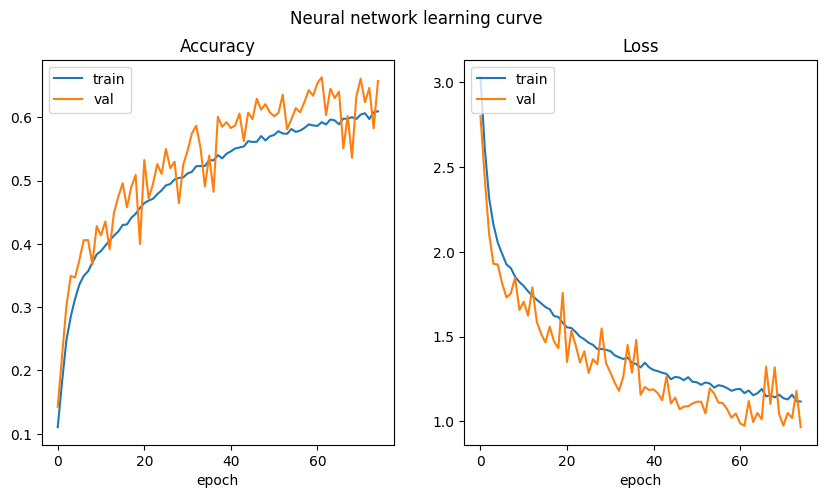

In [19]:
plot_curves(history, title="Neural network learning curve",save_fig=trained)

In [20]:
nn_model_res = evaluate_model(nn_model,test_ds,verbose=3,savePath=MODEL_DIR+"/nn_model.keras")

544/544 [==============================] - 2s 3ms/step - loss: 0.9653 - accuracy: 0.6566
Test loss: 0.9653231501579285
Test accuracy: 0.656551718711853
Model saved to models/nn_model.keras


# CNN

In [21]:
simple_cnn_model = tf.keras.Sequential([
  
  tf.keras.layers.Conv2D(32, 7,padding='same',strides=2),#56x56
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(2),#28x28

  tf.keras.layers.Conv2D(64, 5,padding='same',strides=1),#28x28
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(2),#14x14

  tf.keras.layers.Conv2D(128, 3,padding='same',strides=1),#14x14
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(2),#7x7
  
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes)
])
simple_cnn_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
simple_cnn_model.build([None,*INPUT_SHAPE])
simple_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 32)        4736      
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 32)       128       
 ormalization)                                                   
                                                                 
 activation_3 (Activation)   (None, 56, 56, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)      

In [22]:


model_backup_callback = tf.keras.callbacks.BackupAndRestore(backup_dir=BACKUP_FILEPATH+"/simple_cnn_model")

trained = False

if OVERWRITE_MODEL or not os.path.exists(MODEL_DIR+"/simple_cnn.keras"):
  
  history = simple_cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[model_backup_callback]
  )
  trained = True
else:
  simple_cnn_model.load_weights(MODEL_DIR+"/simple_cnn_model.keras")

Epoch 1/50
1632/1632 [==============================] - 19s 9ms/step - loss: 1.9769 - accuracy: 0.4507 - val_loss: 0.8690 - val_accuracy: 0.7271
Epoch 2/50
1632/1632 [==============================] - 12s 8ms/step - loss: 0.5145 - accuracy: 0.8414 - val_loss: 0.4014 - val_accuracy: 0.8670
Epoch 3/50
1632/1632 [==============================] - 14s 8ms/step - loss: 0.2447 - accuracy: 0.9257 - val_loss: 0.3767 - val_accuracy: 0.8714
Epoch 4/50
1632/1632 [==============================] - 19s 12ms/step - loss: 0.1517 - accuracy: 0.9538 - val_loss: 0.3175 - val_accuracy: 0.8905
Epoch 5/50
1632/1632 [==============================] - 29s 18ms/step - loss: 0.1020 - accuracy: 0.9687 - val_loss: 0.1021 - val_accuracy: 0.9670
Epoch 6/50
1632/1632 [==============================] - 15s 9ms/step - loss: 0.0773 - accuracy: 0.9764 - val_loss: 0.0509 - val_accuracy: 0.9845
Epoch 7/50
1632/1632 [==============================] - 30s 19ms/step - loss: 0.0643 - accuracy: 0.9807 - val_loss: 0.2212 - val

In [23]:
cnn_model_res = evaluate_model(simple_cnn_model,test_ds,verbose=3,savePath=MODEL_DIR+"/simple_cnn_model.keras")

544/544 [==============================] - 7s 13ms/step - loss: 0.0158 - accuracy: 0.9949
Test loss: 0.015782782807946205
Test accuracy: 0.9949425458908081
Model saved to models/simple_cnn_model.keras


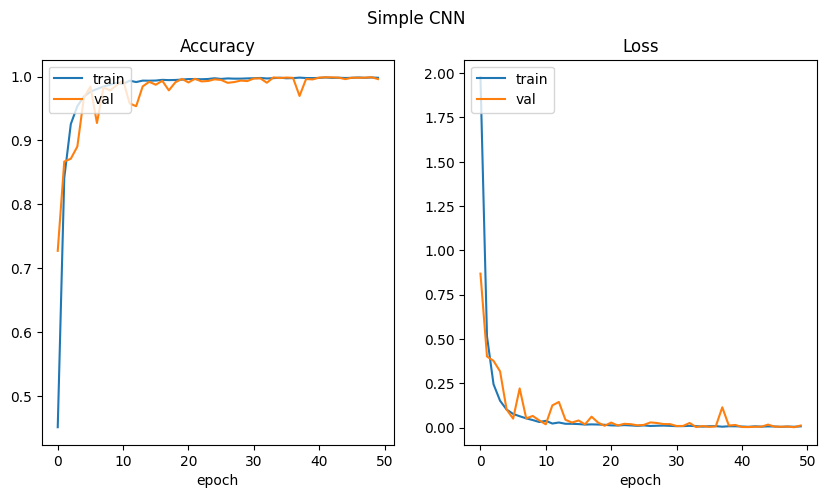

In [24]:
plot_curves(history, title="Simple CNN",save_fig=trained)

## CNN - 12-layer Resnet

In [25]:
from dataTransformer import *

resnet_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 7,padding='same',strides=2),#56x56
  ResnetBlock(5,filt=64,filt_in=32,num=2,stride=2),#28x28
  ResnetBlock(5,filt=64,num=2),

  ResnetBlock(3,filt=128,filt_in=64,num=2,stride=2),#14x14
  ResnetBlock(3,filt=128,filt_in=128,num=2),

  ResnetBlock(3,filt=256,filt_in=128,num=2,stride=2),#7x7
  ResnetBlock(3,filt=256,filt_in=256,num=2),

  tf.keras.layers.AveragePooling2D(7),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes)
])
resnet_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
resnet_model.build([None,*INPUT_SHAPE])
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 56, 56, 32)        4736      
                                                                 
 resnet_block (ResnetBlock)  (None, 28, 28, 64)        205760    
                                                                 
 resnet_block_1 (ResnetBlock  (None, 28, 28, 64)       308160    
 )                                                               
                                                                 
 resnet_block_2 (ResnetBlock  (None, 14, 14, 128)      296832    
 )                                                               
                                                                 
 resnet_block_3 (ResnetBlock  (None, 14, 14, 128)      296192    
 )                                                               
                                                      

In [26]:
model_backup_callback = tf.keras.callbacks.BackupAndRestore(
    backup_dir=BACKUP_FILEPATH+"/resnet_model")

trained = False

if OVERWRITE_MODEL or not os.path.exists(MODEL_DIR+"/resnet_model.keras"):
  
  history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[model_backup_callback]
  )
  trained = True
else:
  resnet_model.load_weights(MODEL_DIR+"/resnet_model.keras")

Epoch 1/25
1632/1632 [==============================] - 60s 32ms/step - loss: 0.8858 - accuracy: 0.7355 - val_loss: 0.4214 - val_accuracy: 0.8833
Epoch 2/25
1632/1632 [==============================] - 46s 28ms/step - loss: 0.1079 - accuracy: 0.9669 - val_loss: 0.1440 - val_accuracy: 0.9620
Epoch 3/25
1632/1632 [==============================] - 34s 21ms/step - loss: 0.0639 - accuracy: 0.9798 - val_loss: 0.1725 - val_accuracy: 0.9436
Epoch 4/25
1632/1632 [==============================] - 94s 57ms/step - loss: 0.0415 - accuracy: 0.9876 - val_loss: 0.0212 - val_accuracy: 0.9930
Epoch 5/25
1632/1632 [==============================] - 68s 41ms/step - loss: 0.0346 - accuracy: 0.9893 - val_loss: 0.0178 - val_accuracy: 0.9941
Epoch 6/25
1632/1632 [==============================] - 51s 31ms/step - loss: 0.0276 - accuracy: 0.9919 - val_loss: 0.1807 - val_accuracy: 0.9460
Epoch 7/25
1632/1632 [==============================] - 46s 28ms/step - loss: 0.0263 - accuracy: 0.9916 - val_loss: 0.0652 -

In [33]:
resnet_model_res = evaluate_model(resnet_model,test_ds,verbose=3,savePath=MODEL_DIR+"/resnet_model.keras")

544/544 [==============================] - 5s 8ms/step - loss: 0.0093 - accuracy: 0.9971
Test loss: 0.009330874308943748
Test accuracy: 0.9971264600753784
Model saved to modelsresnet_model.keras


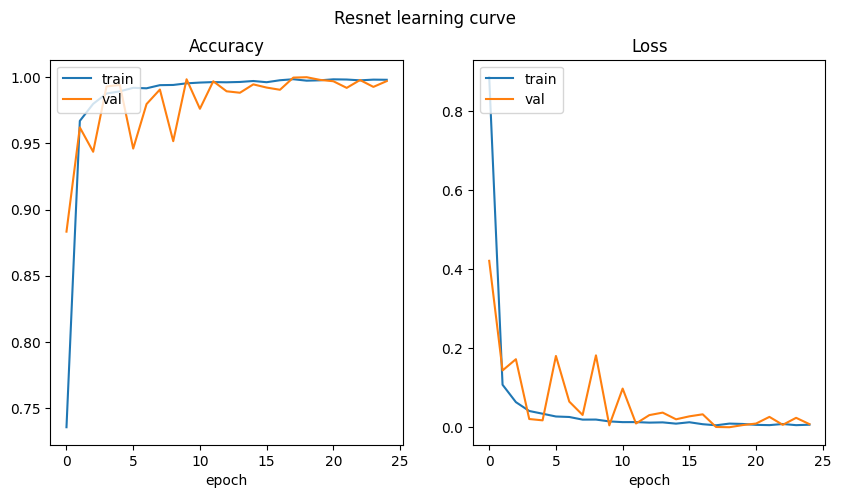

In [28]:
plot_curves(history,title="Resnet learning curve",save_fig=trained)

## Comparison

tf.Tensor([ 3  6 14 ... 26  1 10], shape=(17400,), dtype=int32)


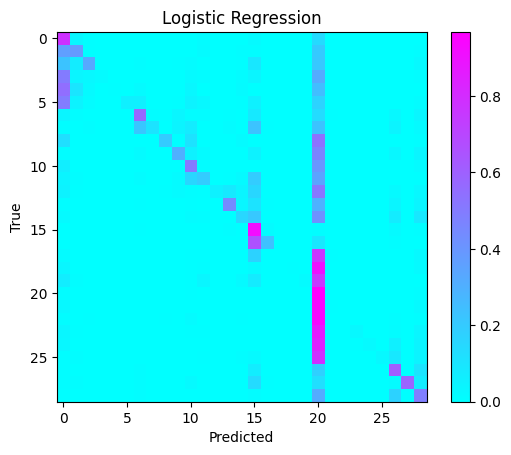

In [29]:
from dataTransformer import *
confusion_matrix(lr_model,test_ds,class_names,title="Logistic Regression",save_fig=True)

tf.Tensor([ 3  6 14 ... 26  1 10], shape=(17400,), dtype=int32)


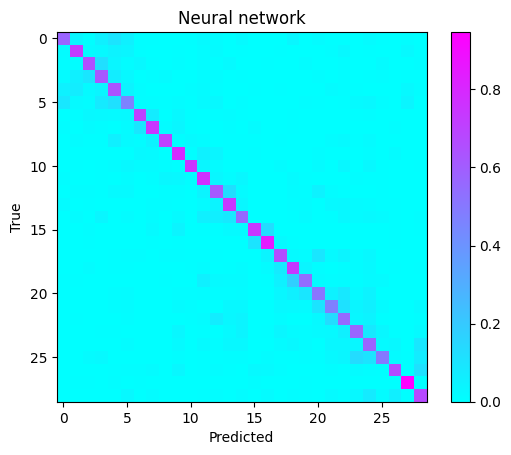

In [30]:
confusion_matrix(nn_model,test_ds,class_names,title="Neural network",save_fig=True)

tf.Tensor([ 3  6 14 ... 26  1 10], shape=(17400,), dtype=int32)


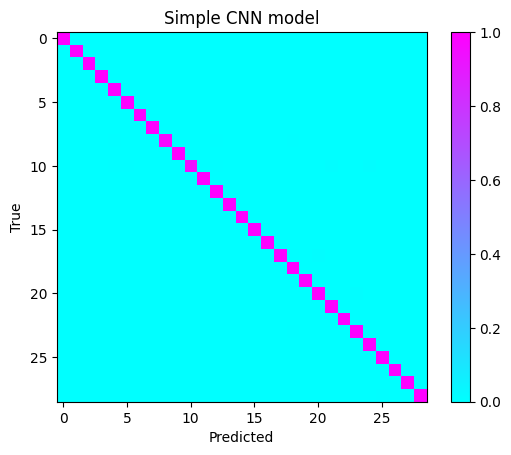

In [31]:
confusion_matrix(simple_cnn_model,test_ds,class_names,title="Simple CNN model",save_fig=True)

tf.Tensor([ 3  6 14 ... 26  1 10], shape=(17400,), dtype=int32)


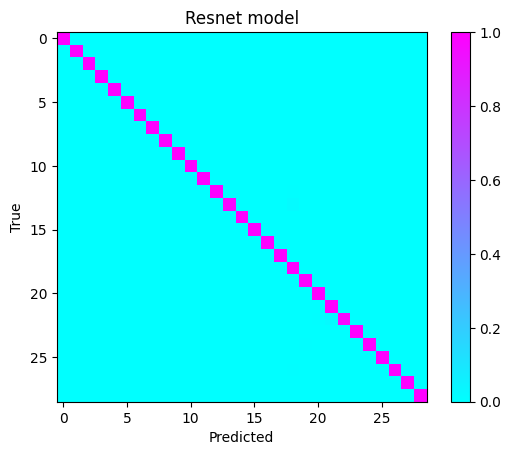

In [32]:
confusion_matrix(resnet_model,test_ds,class_names,title="Resnet model",save_fig=True)